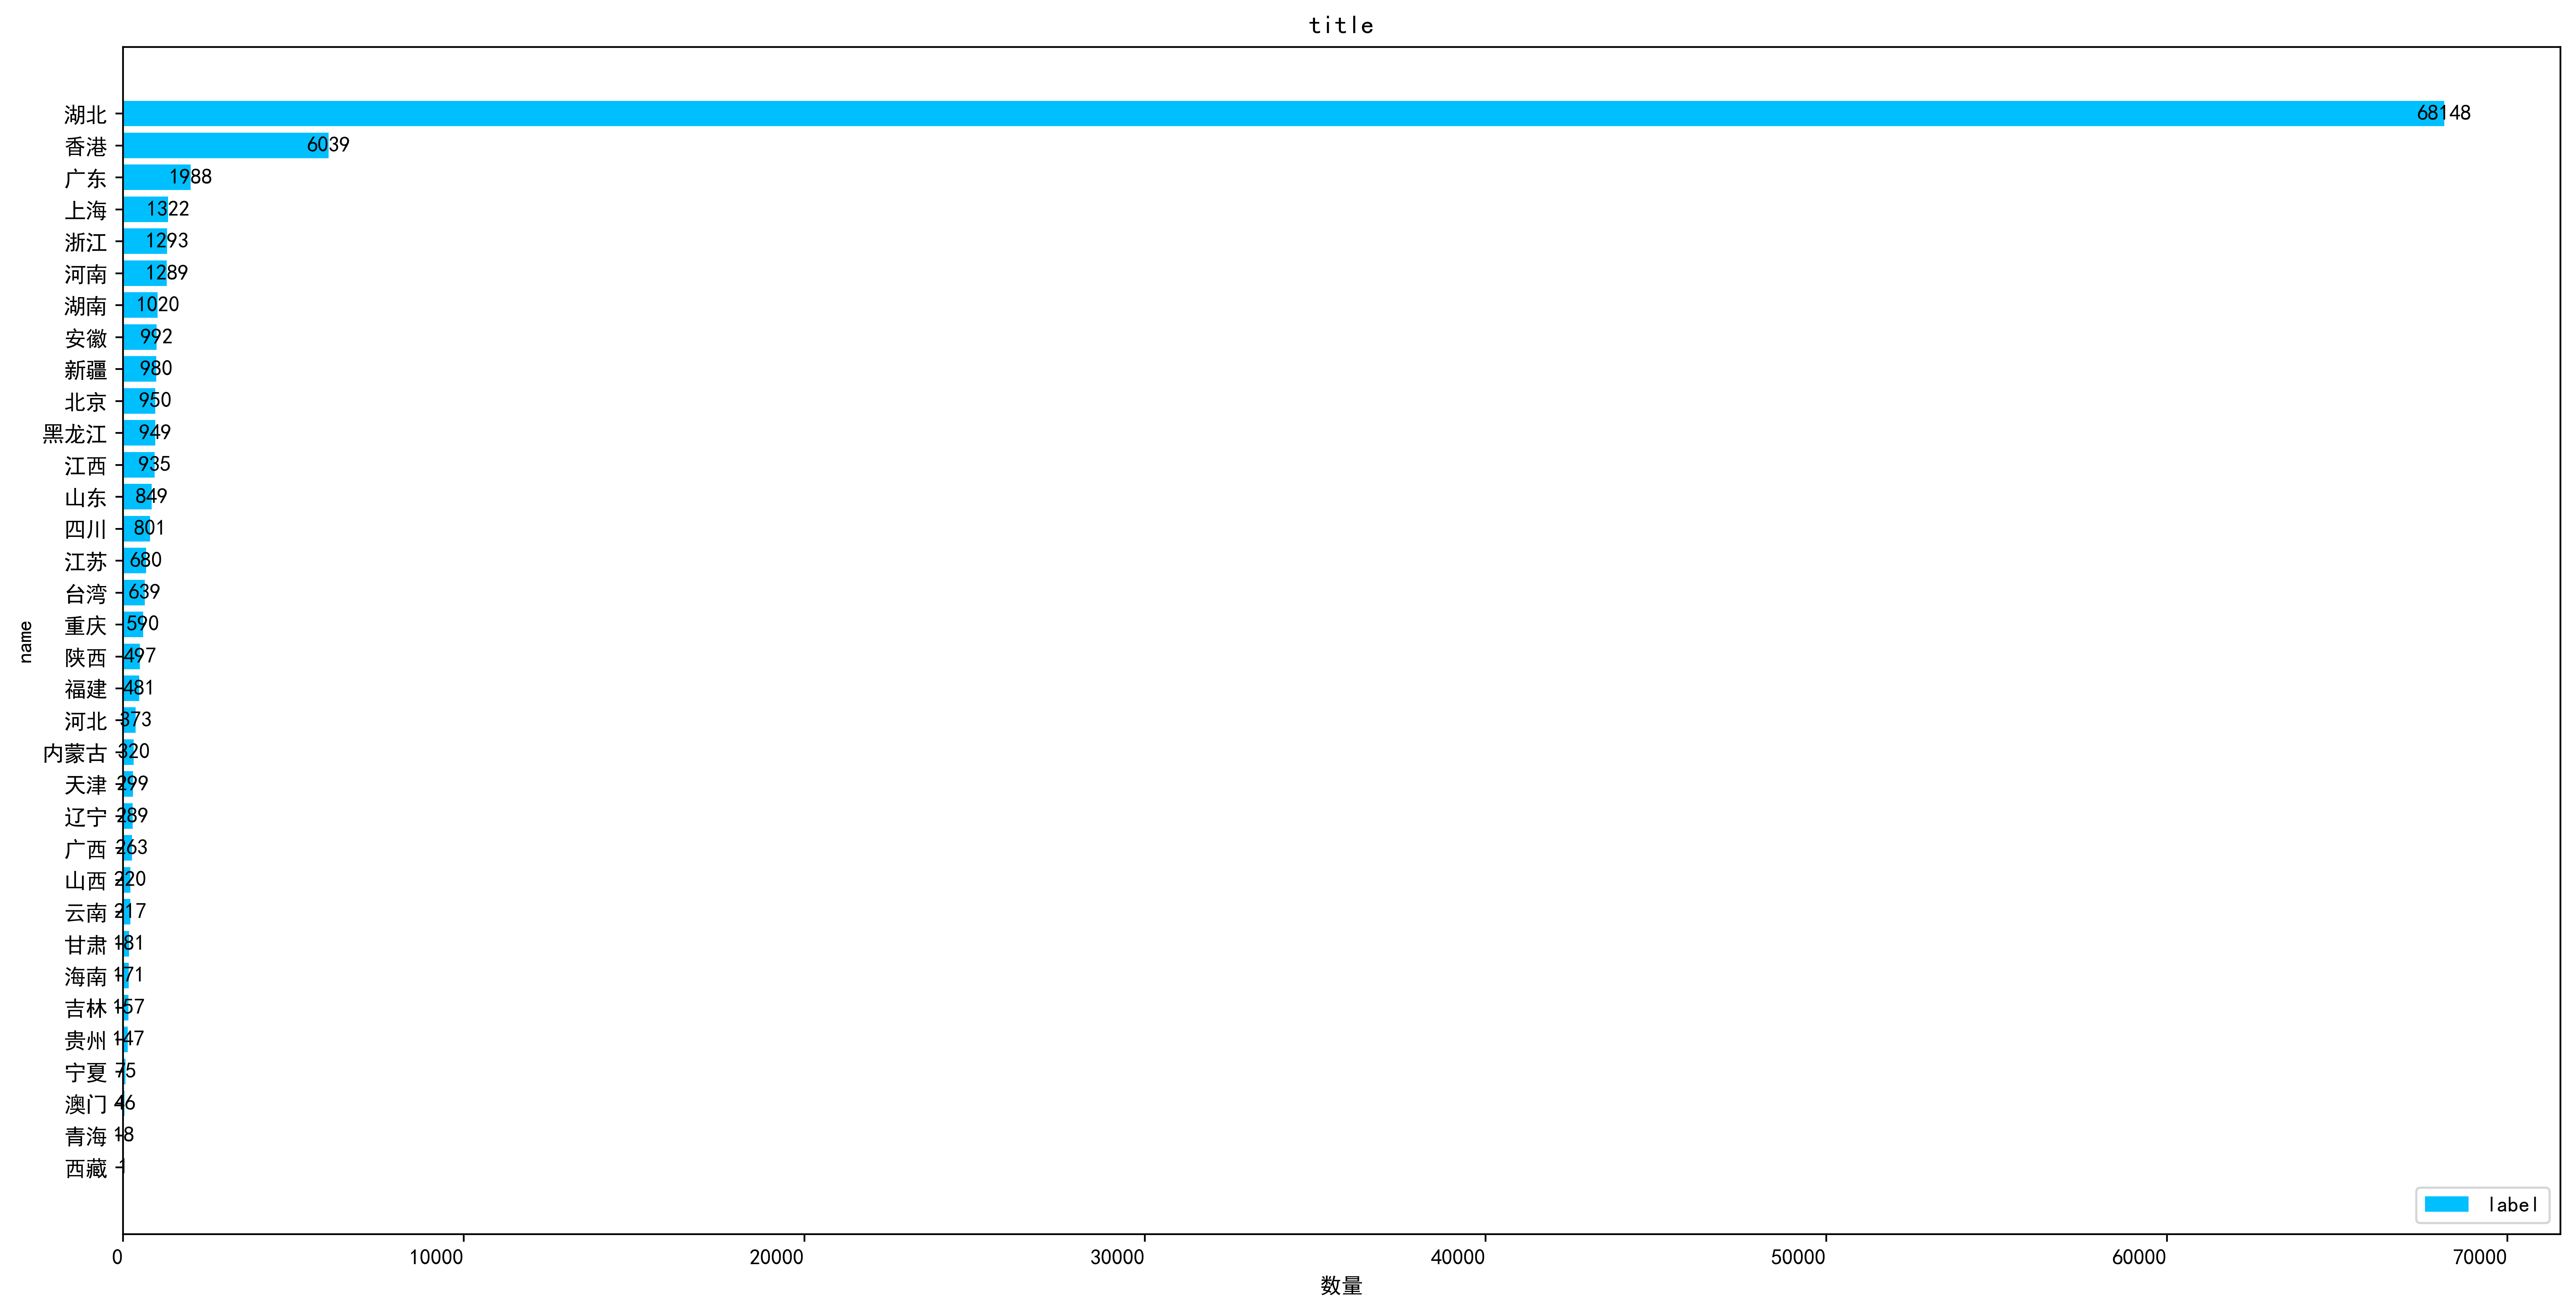

D:\rgzn\lib\site-packages\ipykernel_launcher.py:123: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
D:\rgzn\lib\site-packages\ipykernel_launcher.py:126: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
D:\rgzn\lib\site-packages\ipykernel_launcher.py:127: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
D:\rgzn\lib\site-packages\ipykernel_launcher.py:129: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


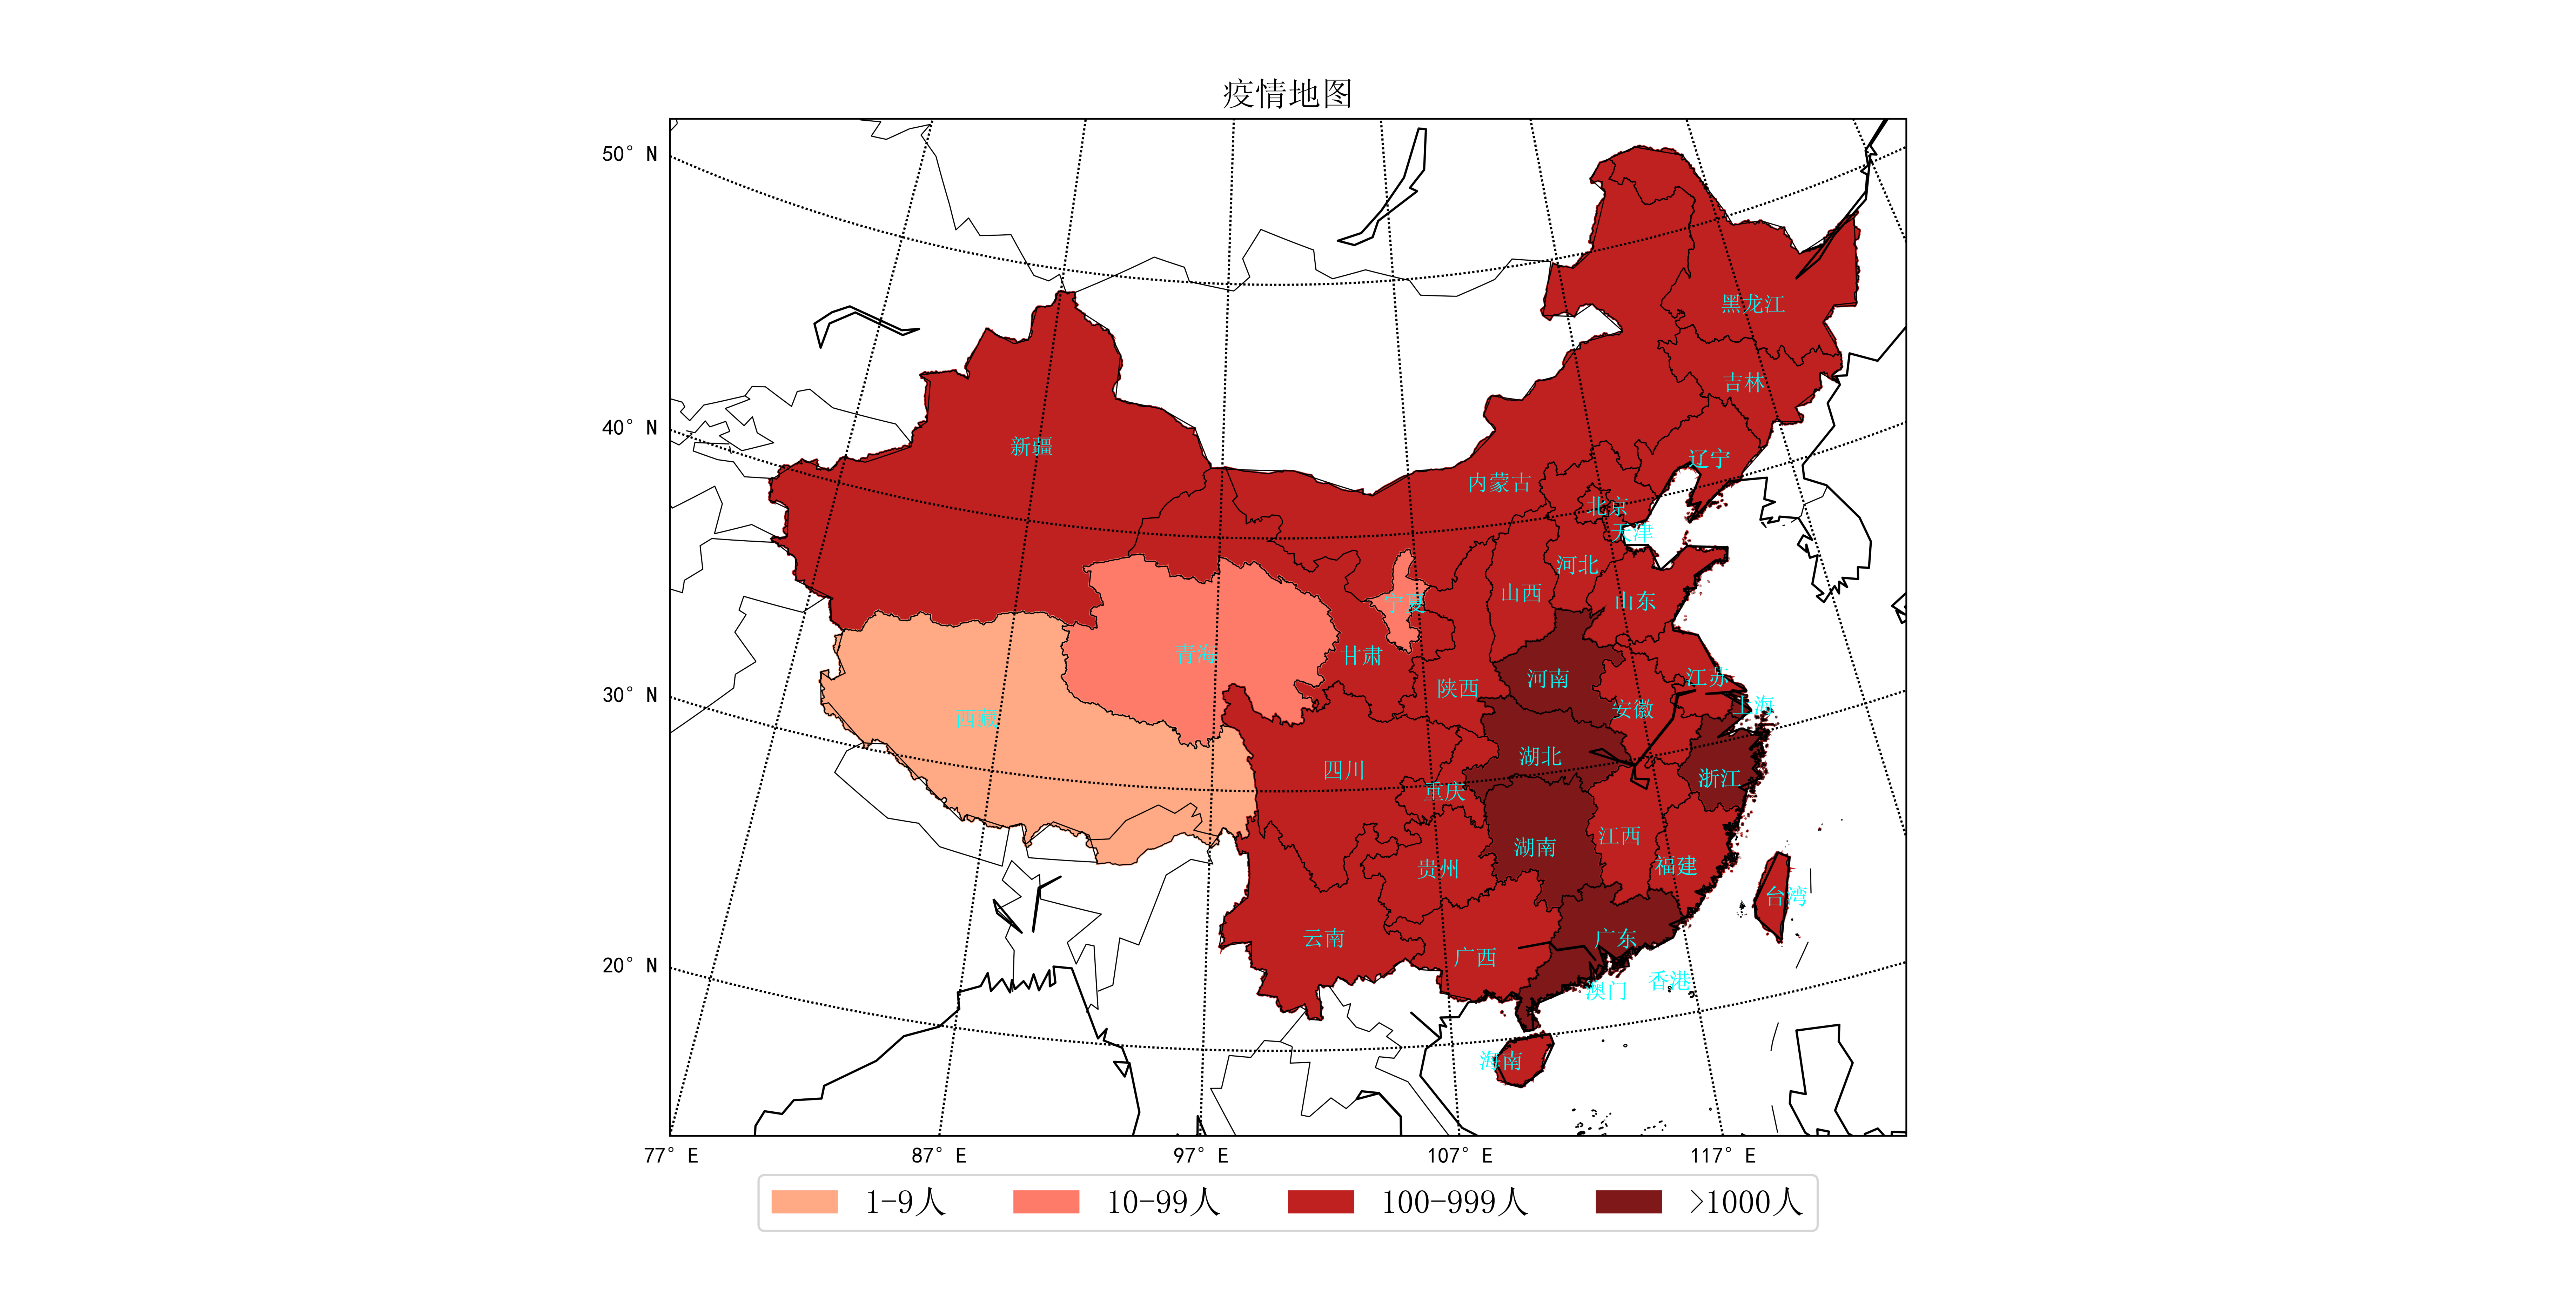

In [26]:
import time
import json
import requests
from datetime import datetime
import numpy as np
import matplotlib
import matplotlib.figure
import matplotlib.image as mpimg
from matplotlib.font_manager import FontProperties
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.rcParams['font.sans-serif'] = ['FangSong']  # 设置默认字体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时乱码问题

def get_everyday_data(everyday_data_url):
    '''
    获取每天的数据
    :param everyday_data_url: 存放每天数据的路径
    :return: 返回每天的数据列表，分确诊、疑似、死亡和治愈
    '''
    data = json.loads(requests.get(url=everyday_data_url).json()['data'])  # 获取数据
    data.sort(key=lambda x: x['date'])  # 将数据按照时间升序排序

    # 定义相关数据列表：日期列表、确诊列表、疑似列表、死亡列表、治愈列表
    date_list, confirm_list, suspect_list, dead_list, heal_list = list(), list(), list(), list(), list()

    # 迭代数据，得到需要的数据
    for item in data:
        month, day = item['date'].split('/')
        date_list.append(datetime.strptime('2020-%s-%s' % (month, day), '%Y-%m-%d'))  # 格式化日期
        confirm_list.append(int(item['confirm']))
        suspect_list.append(int(item['suspect']))
        dead_list.append(int(item['dead']))
        heal_list.append(int(item['heal']))

    return date_list, confirm_list, suspect_list, dead_list, heal_list

def get_area_distribution_data(area_distribution_data_url):
    '''
    获取各区域确诊分布数据
    :param area_distribution_data_url: 存放区域分布数据的路径
    :return: 返回各区域确诊的字典数据
    '''
    result_data = {}  # 存储结果数据的字典
    data = json.loads(requests.get(url=area_distribution_data_url).json()['data'])['areaTree'][0]['children']  # 获取数据

    # 迭代数据，获取需要的数据
    for item in data:
        if item['name'] not in result_data:  # 将区域名称设置为字典的key
            result_data.update({item['name']: 0})

        for city_data in item['children']:  # 将确诊数据作为字典的value
            result_data[item['name']] += int(city_data['total']['confirm'])

    return result_data

def plot_curve_graph():
    result_data = get_area_distribution_data(area_distribution_data_url)  # 获取每天的数据
    s = sorted(result_data.items(), key=lambda x: x[1], reverse=False)  # 对dict 按照value排序 True表示翻转 ,转为了列表形式
    x_x = []
    y_y = []
    for i in s:
        x_x.append(i[0])
        y_y.append(i[1])

    x = x_x
    y = y_y
    
    fig, ax = plt.subplots()
    ax.barh(x, y, color="deepskyblue")
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=0, horizontalalignment='right')
    
    for a, b in zip(x, y):
        plt.text(b+1, a, b, ha='center', va='center')
    ax.legend(["label"],loc="lower right")
    
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    plt.ylabel('city')
    plt.xlabel('确诊人数')
    plt.rcParams['savefig.dpi'] = 640  # 图片像素
    plt.rcParams['figure.dpi'] = 480  # 分辨率
    plt.rcParams['figure.figsize'] = (20.0, 10.0)  # 尺寸
    plt.title("疫情柱状图")
    
    plt.savefig('疫情柱状图.png')
    plt.show()
def plot_distribution_graph(province_positions):
    '''
    绘制各区域确诊分布图
    :param province_positions: 各省位置
    :return:
    '''
    data = get_area_distribution_data(area_distribution_data_url)  # 获取各区域确诊分布数据

    # 相关参数设置
    width, height, rect, lat_min, lat_max, lon_min, lon_max = 1600, 800, [0.1, 0.12, 0.8, 0.8], 0, 60, 77, 140
    # 全局经纬投影替换为如下设置
    # width, height, rect, lat_min, lat_max, lon_min, lon_max = 3000, 1500, [0, 0, 1, 1], -90, 90, 0, 360

    # 匹配图例颜色
    handles = [
        matplotlib.patches.Patch(color='#ffaa85', alpha=1, linewidth=0),
        matplotlib.patches.Patch(color='#ff7b69', alpha=1, linewidth=0),
        matplotlib.patches.Patch(color='#bf2121', alpha=1, linewidth=0),
        matplotlib.patches.Patch(color='#7f1818', alpha=1, linewidth=0),
    ]
    # 设置图例标签
    labels = ['1-9人', '10-99人', '100-999人', '>1000人']

    fig = matplotlib.figure.Figure()
    # 设置绘图板尺寸
    fig.set_size_inches(width / 100, height / 100)
    axes = fig.add_axes(rect)

    # 局部兰博托投影
    m = Basemap(projection='lcc', llcrnrlon=77, llcrnrlat=14, urcrnrlon=140, urcrnrlat=51, lat_1=33, lat_2=45,
                lon_0=100, ax=axes)

    # 读取shape文件，shape文件主要的作用是：画海陆分界线、国界线、行政分界线。
    m.readshapefile('files/shapefiles/china', 'province', drawbounds=True)
    m.readshapefile('files/shapefiles/china_nine_dotted_line', 'section', drawbounds=True)
    m.drawcoastlines(color='black')  # 洲际线
    m.drawcountries(color='black')  # 国界线
    m.drawparallels(np.arange(lat_min, lat_max, 10), labels=[1, 0, 0, 0])  # 画经度线
    m.drawmeridians(np.arange(lon_min, lon_max, 10), labels=[0, 0, 0, 1])  # 画纬度线

    for p_info, p_shape in zip(m.province_info, m.province):  # 分析shape文件，得到相关省数据
        p_name = p_info['OWNER'].strip('\x00')
        f_cname = p_info['FCNAME'].strip('\x00')
        if p_name != f_cname:  # 不绘制海岛
            continue

        for key in data.keys():  # 设置不同数据范围区域的颜色
            if key in p_name:
                if data[key] == 0:
                    color = '#f0f0f0'
                elif data[key] < 10:
                    color = '#ffaa85'
                elif data[key] < 100:
                    color = '#ff7b69'
                elif data[key] < 1000:
                    color = '#bf2121'
                else:
                    color = '#7f1818'
                break

        # 添加设置的颜色至地图中
        poly = Polygon(p_shape, facecolor=color, edgecolor=color)
        axes.add_patch(poly)

        pos = province_positions[p_name]
        text = p_name.replace("自治区", "").replace("特别行政区", "").replace("壮族", "").replace("维吾尔", "")\
            .replace("回族", "").replace("省", "").replace("市", "")  # 替换省级名称

        # 指定字库并设置字体大小
        font15 = FontProperties(fname='files/fonts/simsun.ttf', size=15)
        font10 = FontProperties(fname='files/fonts/simsun.ttf', size=10)

        pset = set()
        if text not in pset:
            x, y = m(pos[0], pos[1])
            axes.text(x, y, text, fontproperties=font10, color='#00FFFF')
            pset.add(text)
    
    axes.legend(handles, labels, bbox_to_anchor=(0.5, -0.11), loc='lower center', ncol=4, prop=font15)
    axes.set_title("疫情地图", fontproperties=font15)
    FigureCanvasAgg(fig)
    fig.savefig('疫情地图.png')
    lena = mpimg.imread('疫情地图.png')
    plt.imshow(lena) # 显示图片
    plt.axis('off') # 不显示坐标轴
    plt.show()

if __name__ == '__main__':

    ts = int(time.time() * 1000)  # 时间戳
    # 存放每天数据的路径
    everyday_data_url = 'https://view.inews.qq.com/g2/getOnsInfo?name=wuwei_ww_cn_day_counts&callback=&_=%d' % ts
    # 存放区域分布数据的路径
    area_distribution_data_url = 'https://view.inews.qq.com/g2/getOnsInfo?name=disease_h5&callback=&_=%d' % ts

    # 各省位置
    province_positions = {
        "辽宁省": [121.7, 40.9],
        "吉林省": [124.5, 43.5],
        "黑龙江省": [125.6, 46.5],
        "北京市": [116.0, 39.9],
        "天津市": [117.0, 38.7],
        "内蒙古自治区": [110.0, 41.5],
        "宁夏回族自治区": [105.2, 37.0],
        "山西省": [111.0, 37.0],
        "河北省": [114.0, 37.8],
        "山东省": [116.5, 36.0],
        "河南省": [111.8, 33.5],
        "陕西省": [107.5, 33.5],
        "湖北省": [111.0, 30.5],
        "江苏省": [119.2, 32.5],
        "安徽省": [115.5, 31.8],
        "上海市": [121.0, 31.0],
        "湖南省": [110.3, 27.0],
        "江西省": [114.0, 27.0],
        "浙江省": [118.8, 28.5],
        "福建省": [116.2, 25.5],
        "广东省": [113.2, 23.1],
        "台湾省": [120.5, 23.5],
        "海南省": [108.0, 19.0],
        "广西壮族自治区": [107.3, 23.0],
        "重庆市": [106.5, 29.5],
        "云南省": [101.0, 24.0],
        "贵州省": [106.0, 26.5],
        "四川省": [102.0, 30.5],
        "甘肃省": [103.0, 35.0],
        "青海省": [95.0, 35.0],
        "新疆维吾尔自治区": [85.5, 42.5],
        "西藏自治区": [85.0, 31.5],
        "香港特别行政区": [115.1, 21.2],
        "澳门特别行政区": [112.5, 21.2]
    }

    plot_curve_graph()  # 绘制每日疫情曲线图
    plot_distribution_graph(province_positions)  # 绘制各区域确诊分布数据